In [19]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions

In [2]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

### TRAIN: OCT + iPhone

### TEST: Samsung

In [8]:
dataset_iphone = cargar_datos('Datos EMD/iPhone/EMD', 'Datos EMD/iPhone/NO EMD')

In [9]:
dataset_samsung = cargar_datos('Datos EMD/Samsung/EMD', 'Datos EMD/Samsung/NO EMD')

In [10]:
dataset = cargar_datos('Datos EMD/OCT/EMD', 'Datos EMD/OCT/NO EMD')

In [11]:
train_ds = np.concatenate((dataset[0],dataset_iphone[0]))

train_labels = np.concatenate((dataset[1],dataset_iphone[1]))

In [12]:
test_ds = dataset_samsung[0]

test_labels = dataset_samsung[1]

In [13]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [18]:
base_model=tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = tf.keras.applications.xception.preprocess_input(train_ds) 
test_ds = tf.keras.applications.xception.preprocess_input(test_ds)

In [20]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=30,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
6/6 [==============================] - 7s 717ms/step - loss: 0.9326 - accuracy: 0.6099 - val_loss: 1.2544 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 3s 560ms/step - loss: 0.7268 - accuracy: 0.7198 - val_loss: 1.1512 - val_accuracy: 0.0652
Epoch 3/200
6/6 [==============================] - 3s 562ms/step - loss: 0.5839 - accuracy: 0.7253 - val_loss: 0.3236 - val_accuracy: 0.9565
Epoch 4/200
6/6 [==============================] - 3s 550ms/step - loss: 0.4817 - accuracy: 0.8077 - val_loss: 0.7214 - val_accuracy: 0.5435
Epoch 5/200
6/6 [==============================] - 3s 550ms/step - loss: 0.3908 - accuracy: 0.8352 - val_loss: 0.5120 - val_accuracy: 0.7391
Epoch 6/200
6/6 [==============================] - 3s 568ms/step - loss: 0.3363 - accuracy: 0.8571 - val_loss: 0.3316 - val_accuracy: 0.8478
Epoch 7/200
6/6 [==============================] - 4s 634ms/step - loss: 0.2818 - accuracy: 0.8956 - val_loss: 0.5470 - val_accuracy: 0.7174
Epoch 8/2

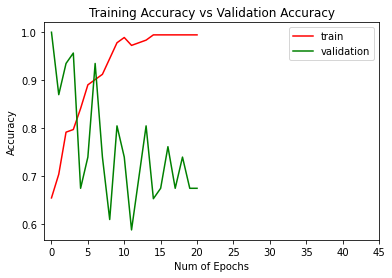

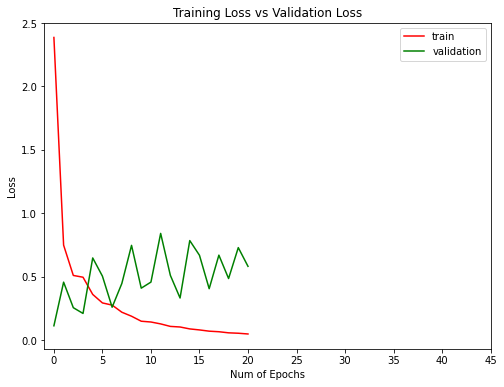

In [22]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

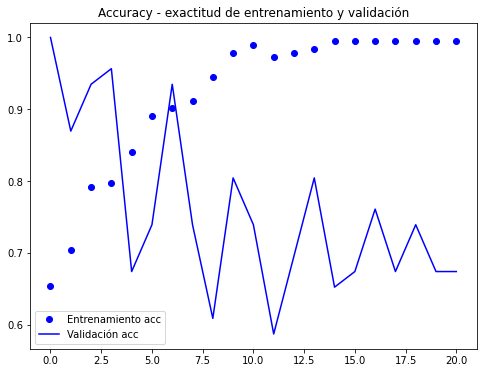

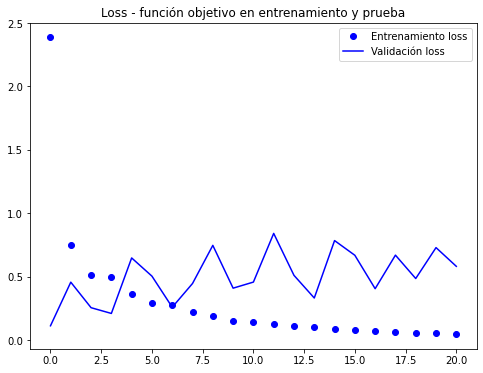

In [23]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 2s 382ms/step


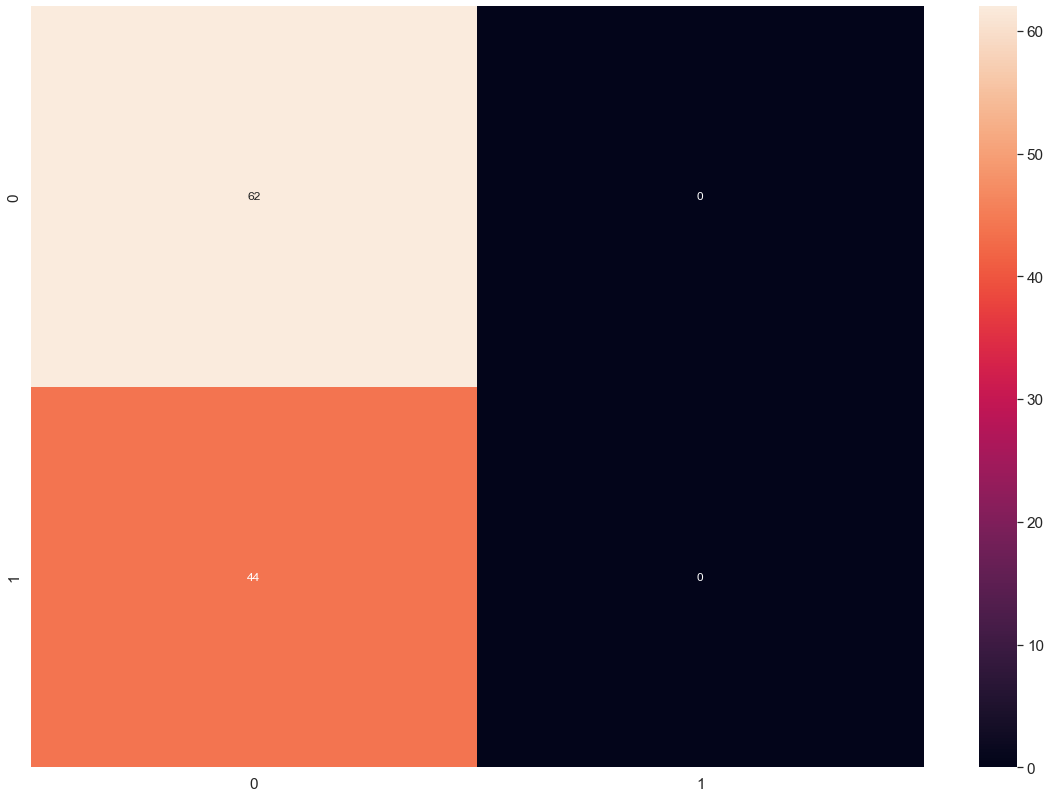

In [24]:
xception = model.predict(test_ds, batch_size=32, verbose=1)  
xception_predicted = np.argmax(xception, axis=1)

xception_cm = confusion_matrix(np.argmax(test_labels, axis=1), xception_predicted)

# Visualizing of confusion matrix
xception_df_cm = pd.DataFrame(xception_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(xception_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

### TRAIN: OCT + Samsung

### TEST: iPhone

In [26]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [27]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [28]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [29]:
base_model=tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = tf.keras.applications.xception.preprocess_input(train_ds) 
test_ds = tf.keras.applications.xception.preprocess_input(test_ds)

In [30]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=30,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
6/6 [==============================] - 8s 798ms/step - loss: 1.2686 - accuracy: 0.6554 - val_loss: 3.3304 - val_accuracy: 0.1111
Epoch 2/200
6/6 [==============================] - 3s 571ms/step - loss: 0.5913 - accuracy: 0.7797 - val_loss: 0.1369 - val_accuracy: 1.0000
Epoch 3/200
6/6 [==============================] - 3s 597ms/step - loss: 0.5286 - accuracy: 0.8079 - val_loss: 0.9017 - val_accuracy: 0.5333
Epoch 4/200
6/6 [==============================] - 3s 576ms/step - loss: 0.3369 - accuracy: 0.8588 - val_loss: 2.7618 - val_accuracy: 0.0889
Epoch 5/200
6/6 [==============================] - 4s 641ms/step - loss: 0.1301 - accuracy: 0.9435 - val_loss: 4.1666 - val_accuracy: 0.0444
Epoch 6/200
6/6 [==============================] - 4s 687ms/step - loss: 0.1218 - accuracy: 0.9548 - val_loss: 1.6726 - val_accuracy: 0.4667
Epoch 7/200
6/6 [==============================] - 4s 651ms/step - loss: 0.0743 - accuracy: 0.9774 - val_loss: 5.2058 - val_accuracy: 0.0000e+00
Epoch 8/2

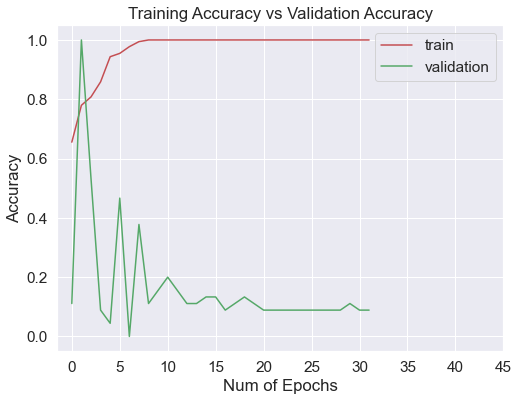

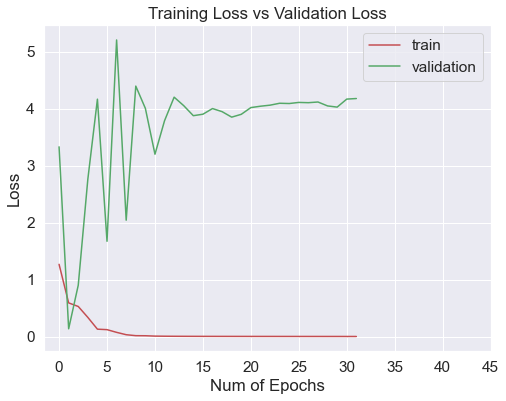

In [32]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

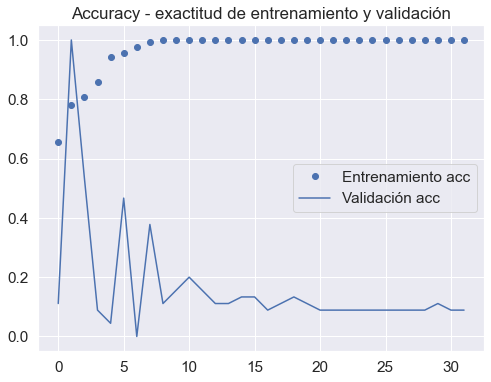

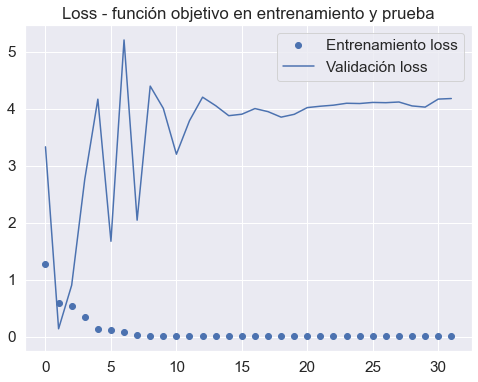

In [33]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 2s 384ms/step


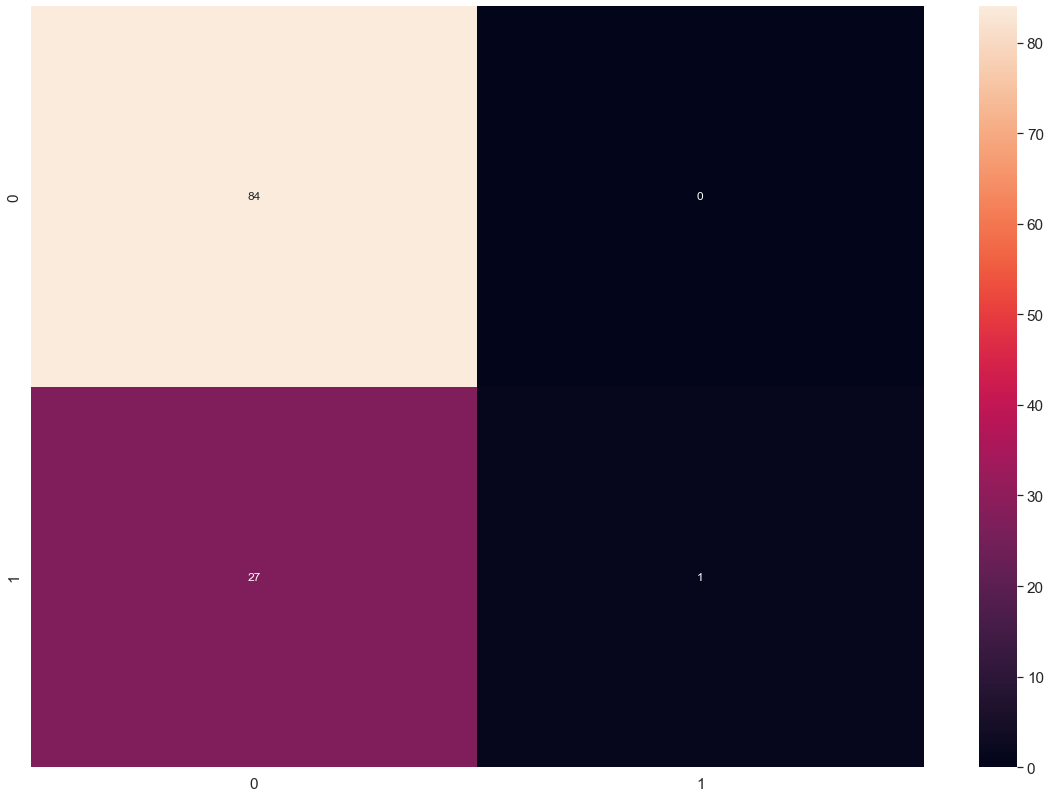

In [34]:
xception = model.predict(test_ds, batch_size=32, verbose=1)  
xception_predicted = np.argmax(xception, axis=1)

xception_cm = confusion_matrix(np.argmax(test_labels, axis=1), xception_predicted)

# Visualizing of confusion matrix
xception_df_cm = pd.DataFrame(xception_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(xception_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 